Estructura del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
 9   high_value        1000 non-null   int32 
dtypes: int32(1), int64(5), object(4)
memory usage: 74.3+ KB
None

Estadísticas descriptivas:
       Transaction ID         Age     Quantity  Price per Unit  Total Amount  \
count     1000.000000  1000.00000  1000.000000     1000.000000   1000.000000   
mean       500.500000    41.39200     2.514000      179.890000

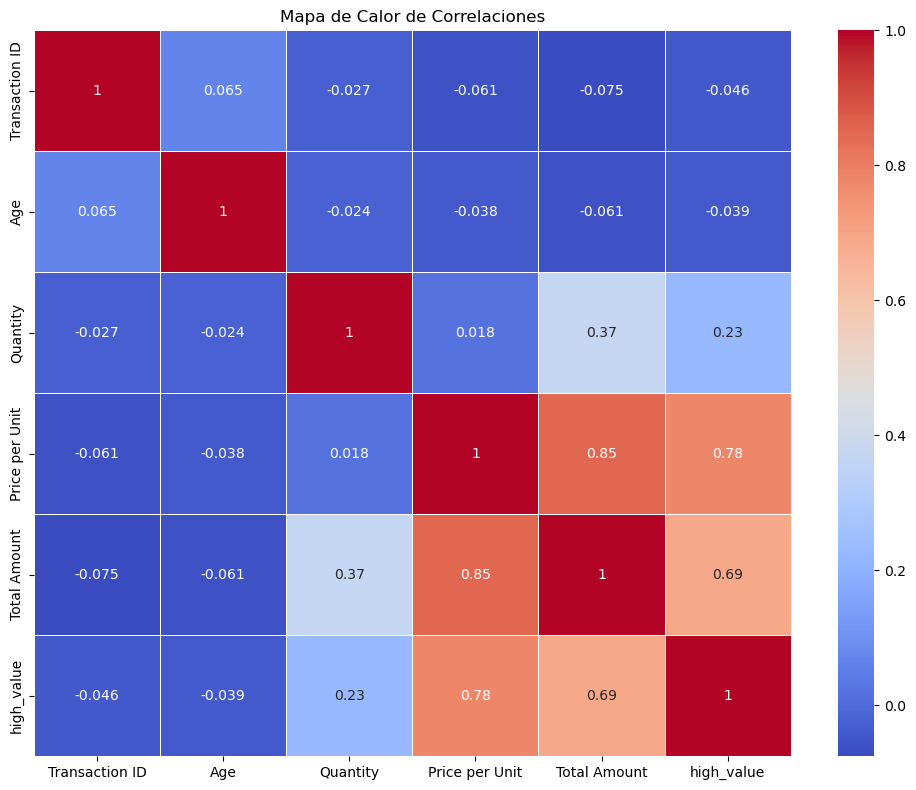

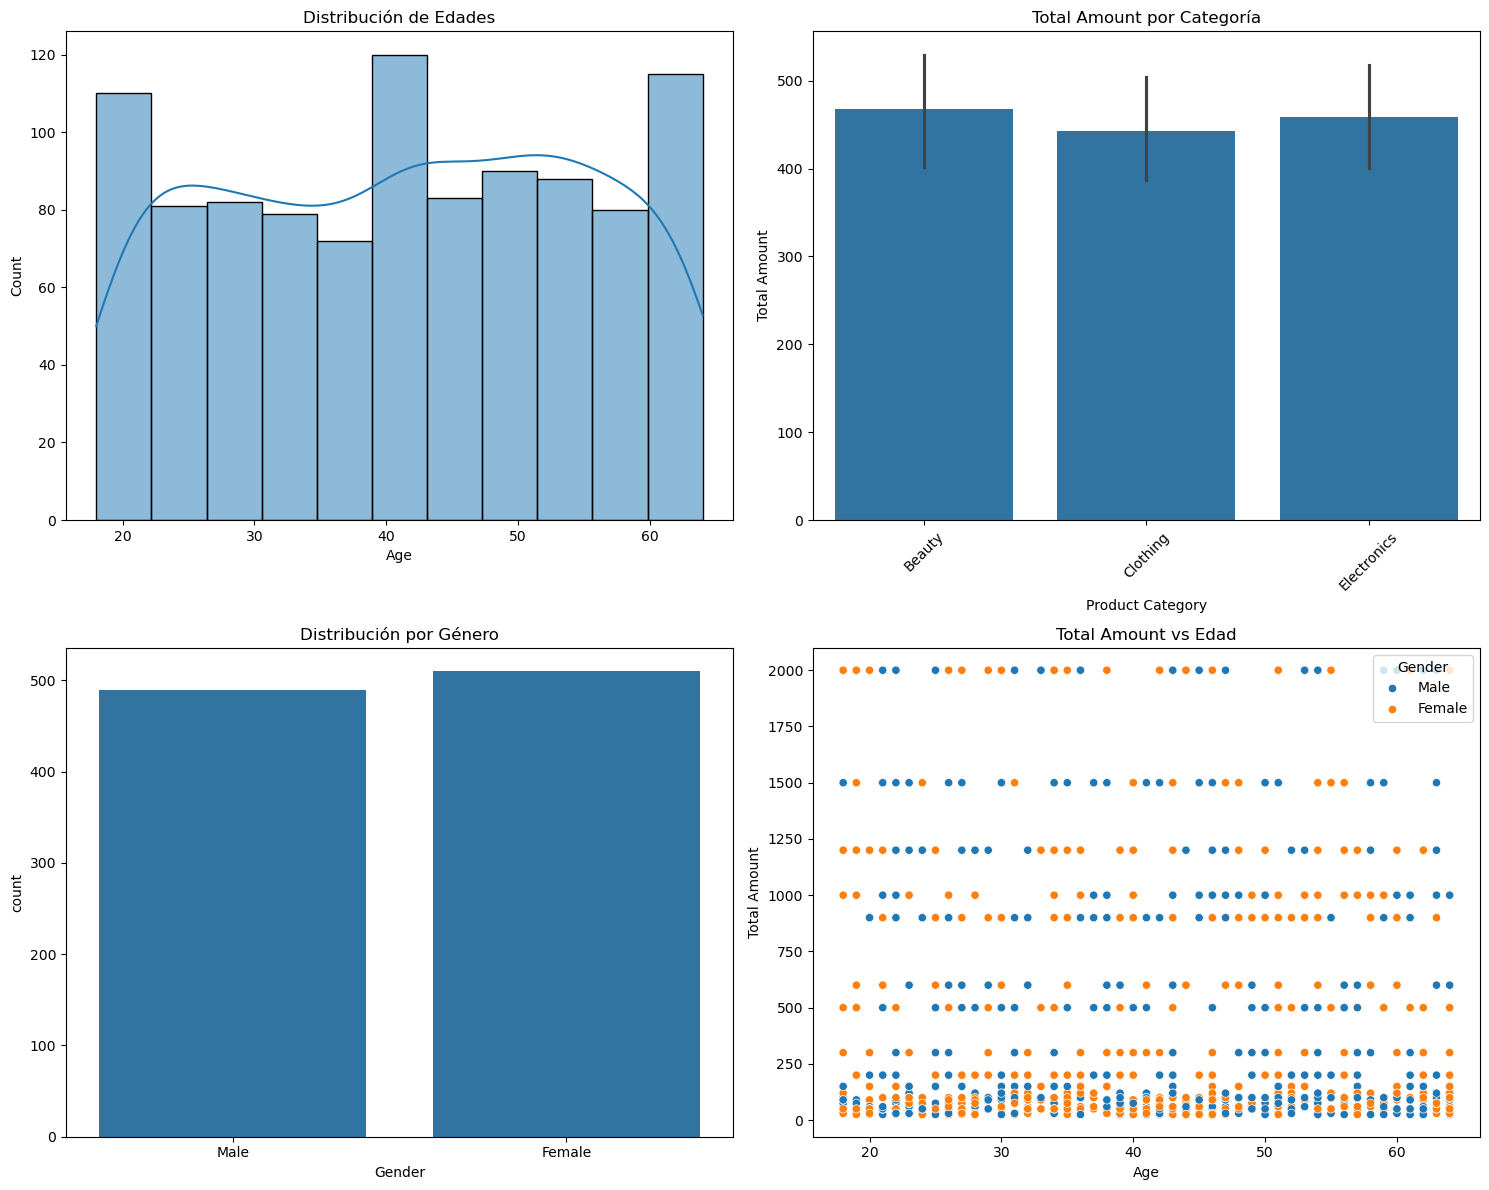

c:\Users\Ivan\miniconda3\envs\env_ds\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:12:32] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 390, number of negative: 410
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487500 -> initscore=-0.050010
[LightGBM] [Info] Start training from score -0.050010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

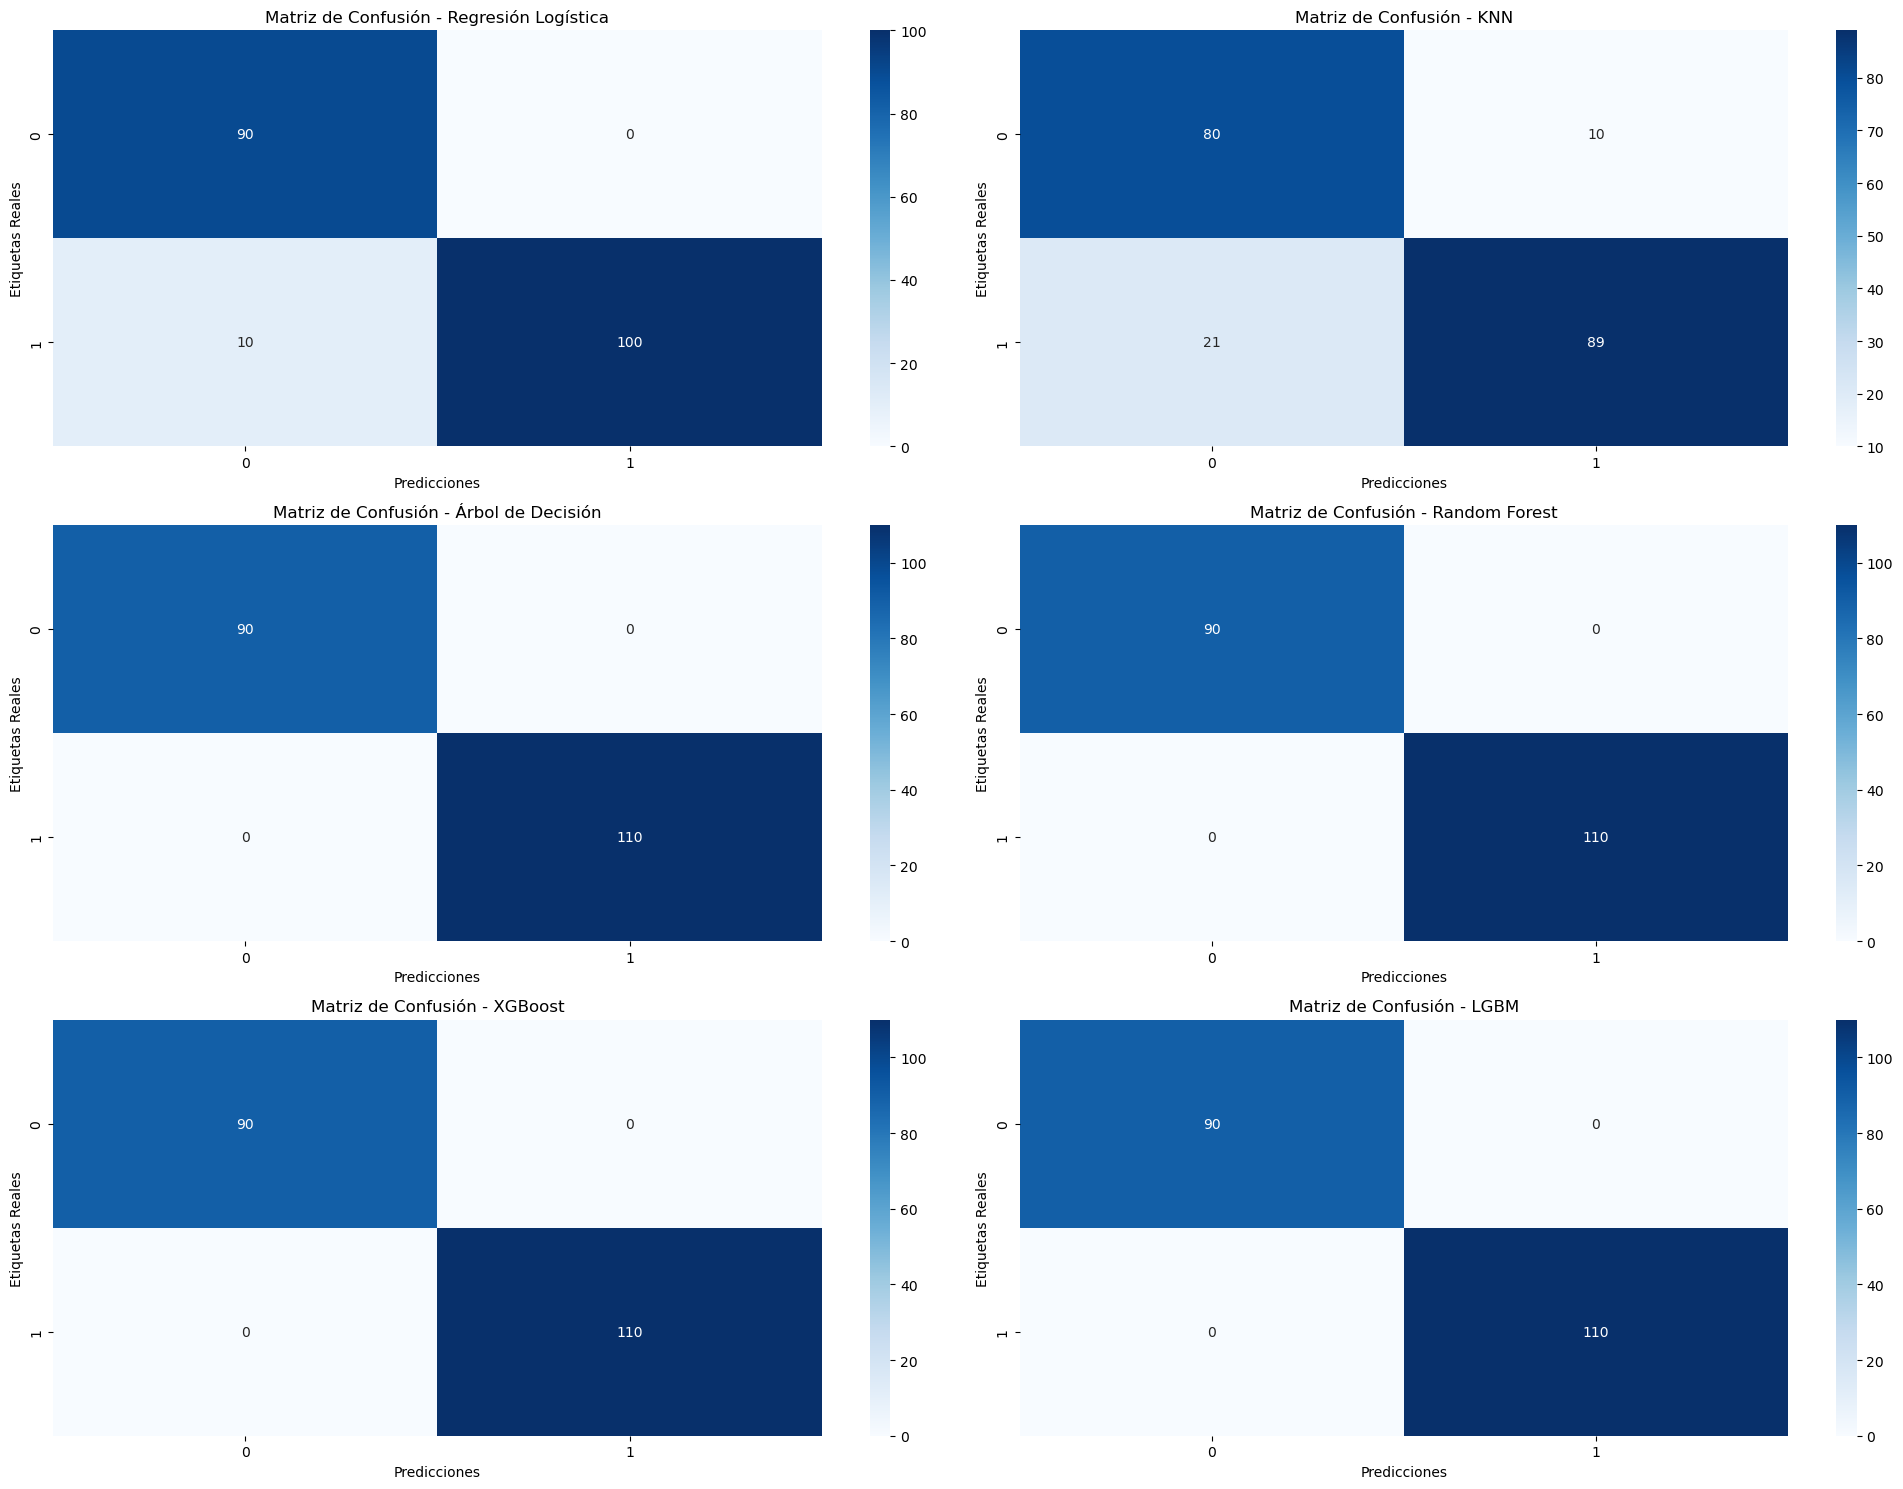

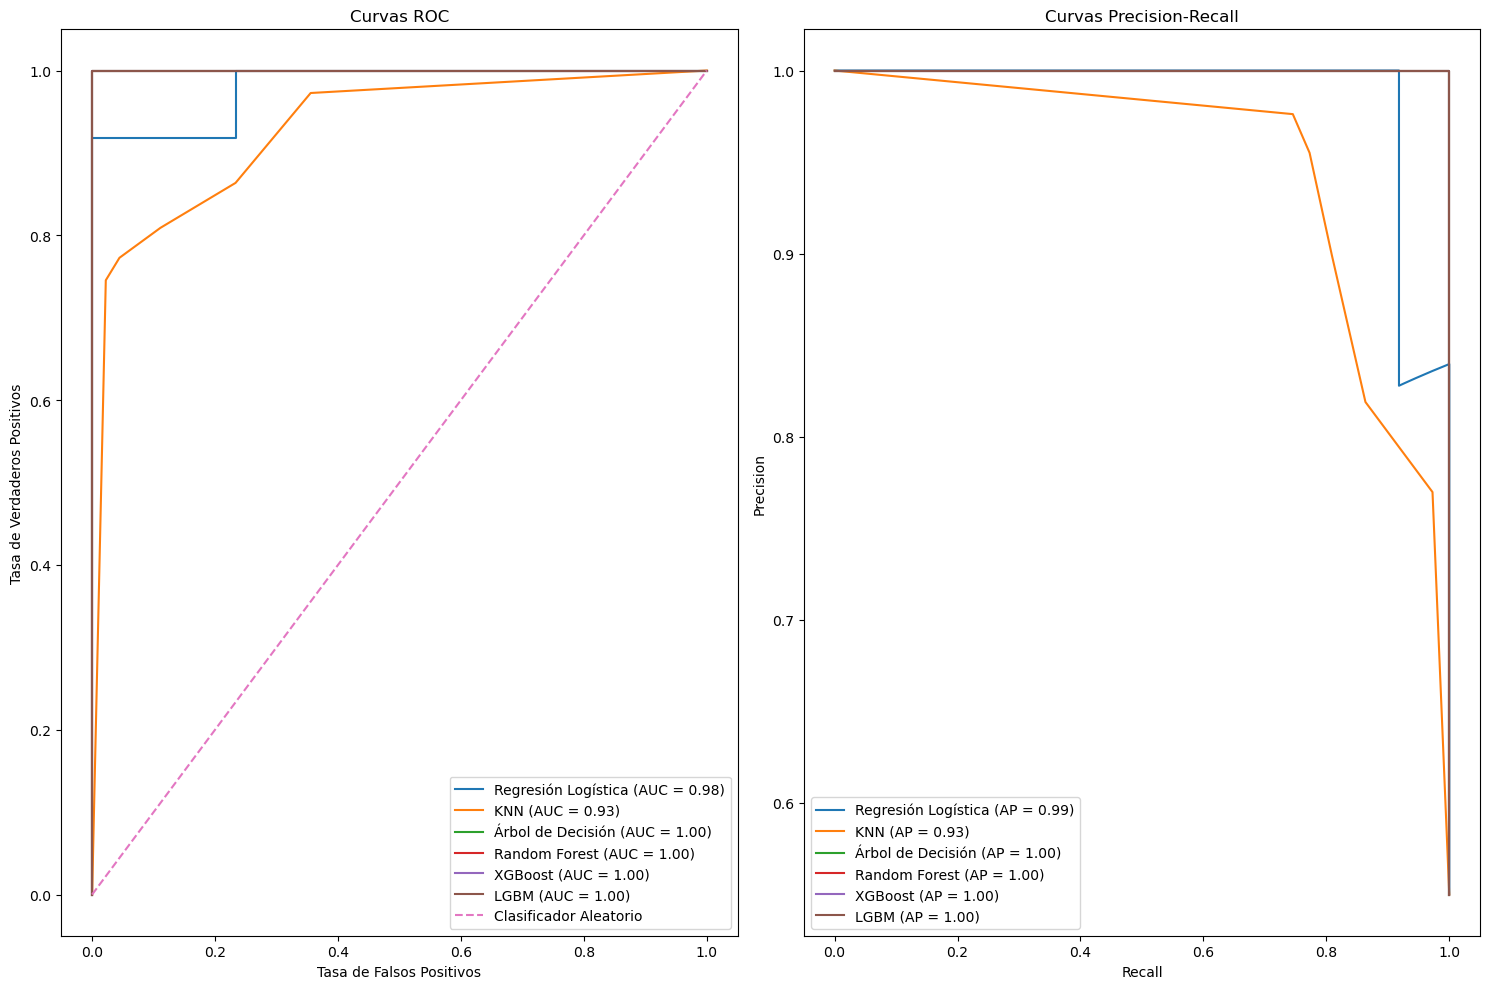

Informes de Clasificación Detallados:

Modelo: Regresión Logística
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        90
           1       1.00      0.91      0.95       110

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

--------------------------------------------------
Modelo: KNN
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        90
           1       0.90      0.81      0.85       110

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200

--------------------------------------------------
Modelo: Árbol de Decisión
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

df = pd.read_csv('../data/retail_sales_dataset.csv')

# Parte 1: Exploración y Visualización de Datos (EDA)
def realizar_eda(df):
    # Descripción básica
    print("Estructura del DataFrame:")
    print(df.info())
    print("\nEstadísticas descriptivas:")
    print(df.describe())
    
    # Análisis de correlación
    plt.figure(figsize=(10, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlacion = df[numeric_cols].corr()
    sns.heatmap(correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Mapa de Calor de Correlaciones')
    plt.tight_layout()
    plt.show()
    
    # Subplots comparativos
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribución de Edades
    sns.histplot(df['Age'], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title('Distribución de Edades')
    
    # Total Amount por Categoría de Producto
    sns.barplot(x='Product Category', y='Total Amount', data=df, ax=axs[0, 1])
    axs[0, 1].set_title('Total Amount por Categoría')
    axs[0, 1].tick_params(axis='x', rotation=45)
    
    # Cantidad por Género
    sns.countplot(x='Gender', data=df, ax=axs[1, 0])
    axs[1, 0].set_title('Distribución por Género')
    
    # Total Amount por Edad
    sns.scatterplot(x='Age', y='Total Amount', hue='Gender', data=df, ax=axs[1, 1])
    axs[1, 1].set_title('Total Amount vs Edad')
    
    plt.tight_layout()
    plt.show()

# Parte 2: Preprocesamiento de Datos
def preprocesar_datos(df):
    # Separar características y target (ejemplo de clasificación)
    df['high_value'] = (df['Total Amount'] > df['Total Amount'].median()).astype(int)
    X = df.drop(['high_value', 'Transaction ID', 'Date', 'Customer ID'], axis=1)
    y = df['high_value']
    
    # Transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Age', 'Quantity', 'Price per Unit']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Product Category'])
        ])
    
    return X, y, preprocessor


def entrenar_modelos(X, y, preprocessor):
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Definir modelos
    modelos = {
        'Regresión Logística': LogisticRegression(max_iter=1000),
        'KNN': KNeighborsClassifier(),
        'Árbol de Decisión': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LGBM': LGBMClassifier()
    }
    
    # Resultados de modelos
    resultados = {}
    
    for nombre, modelo in modelos.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', modelo)
        ])
        
        # Entrenar y evaluar
        pipeline.fit(X_train, y_train)
        
        resultados[nombre] = {
            'Modelo': pipeline,
            'X_test': X_test,
            'y_test': y_test
        }
    
    return resultados

# Parte 4: Análisis de Métricas
def analisis_metricas_detallado(resultados):
    # Configuración de la figura para matrices de confusión y métricas
    plt.figure(figsize=(20, 15))
    
    # Iteración por cada modelo para análisis detallado
    for i, (nombre, resultado) in enumerate(resultados.items(), 1):
        modelo = resultado['Modelo']
        X_test = resultado['X_test']
        y_test = resultado['y_test']
        
        # Predicciones
        y_pred = modelo.predict(X_test)
        y_pred_proba = modelo.predict_proba(X_test)[:, 1]
        
        # Subplot para cada modelo
        plt.subplot(3, 2, i)
        
        # Matriz de Confusión
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusión - {nombre}')
        plt.ylabel('Etiquetas Reales')
        plt.xlabel('Predicciones')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de Curvas ROC y Curvas Precision-Recall
    plt.figure(figsize=(15, 10))
    
    # Curvas ROC
    plt.subplot(1, 2, 1)
    for nombre, resultado in resultados.items():
        modelo = resultado['Modelo']
        X_test = resultado['X_test']
        y_test = resultado['y_test']
        
        y_pred_proba = modelo.predict_proba(X_test)[:, 1]
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Clasificador Aleatorio')
    plt.title('Curvas ROC')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    
    # Curvas Precision-Recall
    plt.subplot(1, 2, 2)
    for nombre, resultado in resultados.items():
        modelo = resultado['Modelo']
        X_test = resultado['X_test']
        y_test = resultado['y_test']
        
        y_pred_proba = modelo.predict_proba(X_test)[:, 1]
        
        # Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        plt.plot(recall, precision, label=f'{nombre} (AP = {avg_precision:.2f})')
    
    plt.title('Curvas Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir informes de clasificación detallados
    print("Informes de Clasificación Detallados:\n")
    for nombre, resultado in resultados.items():
        modelo = resultado['Modelo']
        X_test = resultado['X_test']
        y_test = resultado['y_test']
        
        y_pred = modelo.predict(X_test)
        
        print(f"Modelo: {nombre}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)


def visualizar_resultados_modelos(resultados):
    # Gráfico de métricas comparativas
    plt.figure(figsize=(15, 5))
    
    # Scores de Validación Cruzada
    plt.subplot(1, 3, 1)
    cv_scores = [res['CV Score'] for res in resultados.values()]
    plt.bar(resultados.keys(), cv_scores)
    plt.title('Scores de Validación Cruzada')
    plt.xlabel('Modelos')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    
    # Precisión por Modelo
    plt.subplot(1, 3, 2)
    precisiones = [res['Precision'] for res in resultados.values()]
    plt.bar(resultados.keys(), precisiones)
    plt.title('Precisión por Modelo')
    plt.xlabel('Modelos')
    plt.ylabel('Precisión')
    plt.xticks(rotation=45, ha='right')
    
    # F1-Score por Modelo
    plt.subplot(1, 3, 3)
    f1_scores = [res['F1-Score'] for res in resultados.values()]
    plt.bar(resultados.keys(), f1_scores)
    plt.title('F1-Score por Modelo')
    plt.xlabel('Modelos')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

    # Curvas ROC
    plt.figure(figsize=(10, 6))
    for nombre, resultado in resultados.items():
        modelo = resultado['Modelo']
        X_test = resultado['X_test']
        y_test = resultado['y_test']
        
        y_pred_proba = modelo.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Clasificador Aleatorio')
    plt.title('Curvas ROC de los Modelos')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend()
    plt.show()

# Preprocesamiento
df['high_value'] = (df['Total Amount'] > df['Total Amount'].median()).astype(int)
X = df.drop(['high_value', 'Transaction ID', 'Date', 'Customer ID'], axis=1)
y = df['high_value']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'Quantity', 'Price per Unit']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Product Category'])
    ])
# Ejecutar análisis
realizar_eda(df)
X, y, preprocessor = preprocesar_datos(df)
resultados = entrenar_modelos(X, y, preprocessor)
analisis_metricas_detallado(resultados)